In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,bid,ask,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.667400,196.962600,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.527500,196.822500,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.522500,196.817500,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.092800,196.387200,4.770902e-01


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models_core.build_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2435400, 60, 17]) (samples, look_back, features)
  y_sig     = torch.Size([2435400]) (samples,)
  y_ret     = torch.Size([2435400]) (samples,)
  raw_close = torch.Size([2435400])
  raw_bid   = torch.Size([2435400])
  raw_ask   = torch.Size([2435400])
  end_times = (2435400,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models_core.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1731840, 60, 17])
  y_sig_tr, y_ret_tr = torch.Size([1731840]) torch.Size([1731840])
  X_val = torch.Size([338701, 60, 17])
  y_sig_val, y_ret_val = torch.Size([338701]) torch.Size([338701])
  X_te  = torch.Size([364859, 60, 17])
  y_sig_te, y_ret_te = torch.Size([364859]) torch.Size([364859])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3840, val=751, test=809
Batches → train=60,   val=751,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = dual_lstm.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(17, 32, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.15, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 48, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.15, inplace=False)
  (ln_long): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=96, out_features=1, bias=True)
  (cls_head): Linear(in_features=96, out_features=1, bias=True)
  (cls_ter): Linear(in_features=96, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models_core.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.0005
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.405952,  val = 0.409382

Train target stats:
  mean = 0.2836,  var = 0.0844,  std = 0.2905
Train mean‐predictor baseline:
  RMSE_baseline = 0.290471
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



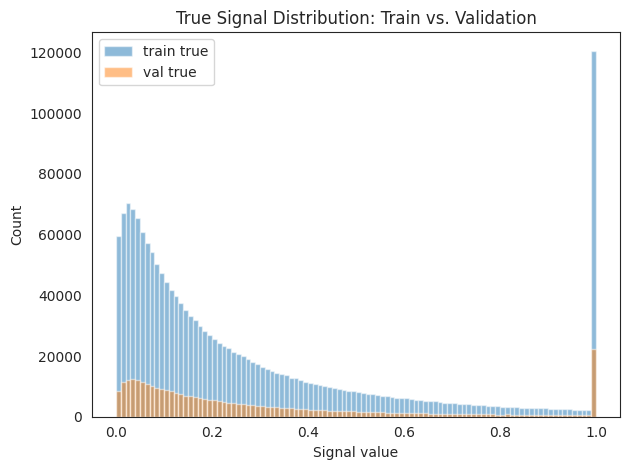

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'SHORT_UNITS': 64, 'LONG_UNITS': 96, 'DROPOUT_SHORT': 0.15, 'DROPOUT_LONG': 0.15, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.15, 'WEIGHT_DECAY': 0.0005, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 4, 'TRAIN_PREFETCH_FACTOR': 2, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7, 'LR_EPOCHS_WARMUP': 3, 'INITIAL_LR': 0.0001, 'CLIPNORM': 0.5, 'ETA_MIN': 1e-06, 'T_0': 100, 'T_MULT': 1, 'HUBER_BETA': 0.1, 'CLS_LOSS_WEIGHT': 0.05, 'PLATEAU_FACTOR': 0.9, 'PLATEAU_PATIENCE': 0, 'MIN_LR': 1e-06, 'PLAT_EPOCHS_WARMUP': 999}


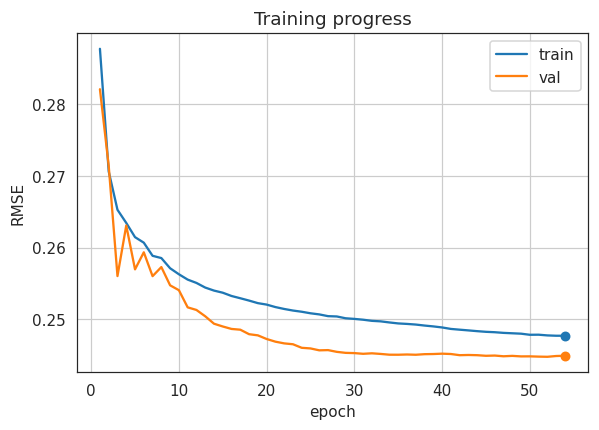

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2877 MAE=0.2269 R2=0.0188 | "B": Acc=0.5982 Prec=0.3146 Rec=0.3841 F1=0.3459 AUROC=0.5474
VALID→ "R": RMSE=0.2821 MAE=0.1968 R2=0.0340 | "B": Acc=0.6677 Prec=0.3987 Rec=0.3083 F1=0.3477 AUROC=0.6129


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2706 MAE=0.2085 R2=0.1320 | "B": Acc=0.6092 Prec=0.3449 Rec=0.4590 F1=0.3939 AUROC=0.5900
VALID→ "R": RMSE=0.2714 MAE=0.1886 R2=0.1059 | "B": Acc=0.6903 Prec=0.4424 Rec=0.2996 F1=0.3573 AUROC=0.6227


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2653 MAE=0.2030 R2=0.1660 | "B": Acc=0.6098 Prec=0.3509 Rec=0.4828 F1=0.4064 AUROC=0.5994
VALID→ "R": RMSE=0.2560 MAE=0.1889 R2=0.2043 | "B": Acc=0.6501 Prec=0.4064 Rec=0.4730 F1=0.4372 AUROC=0.6395


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2634 MAE=0.2020 R2=0.1775 | "B": Acc=0.6043 Prec=0.3523 Rec=0.5131 F1=0.4177 AUROC=0.6044
VALID→ "R": RMSE=0.2631 MAE=0.1839 R2=0.1599 | "B": Acc=0.6686 Prec=0.4219 Rec=0.4144 F1=0.4181 AUROC=0.6430


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2614 MAE=0.2002 R2=0.1899 | "B": Acc=0.6179 Prec=0.3584 Rec=0.4827 F1=0.4114 AUROC=0.6041
VALID→ "R": RMSE=0.2570 MAE=0.1842 R2=0.1985 | "B": Acc=0.6467 Prec=0.4040 Rec=0.4830 F1=0.4400 AUROC=0.6335


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2607 MAE=0.2011 R2=0.1946 | "B": Acc=0.5819 Prec=0.3410 Rec=0.5485 F1=0.4206 AUROC=0.5965
VALID→ "R": RMSE=0.2593 MAE=0.1824 R2=0.1836 | "B": Acc=0.6478 Prec=0.4021 Rec=0.4641 F1=0.4309 AUROC=0.6229


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2588 MAE=0.1978 R2=0.2059 | "B": Acc=0.5910 Prec=0.3445 Rec=0.5297 F1=0.4174 AUROC=0.5966
VALID→ "R": RMSE=0.2560 MAE=0.1825 R2=0.2044 | "B": Acc=0.6369 Prec=0.3938 Rec=0.4892 F1=0.4363 AUROC=0.6191


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2585 MAE=0.1990 R2=0.2078 | "B": Acc=0.5732 Prec=0.3370 Rec=0.5614 F1=0.4212 AUROC=0.5922
VALID→ "R": RMSE=0.2573 MAE=0.1813 R2=0.1965 | "B": Acc=0.6255 Prec=0.3882 Rec=0.5271 F1=0.4471 AUROC=0.6237


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2571 MAE=0.1976 R2=0.2165 | "B": Acc=0.5530 Prec=0.3325 Rec=0.6110 F1=0.4306 AUROC=0.5954
VALID→ "R": RMSE=0.2547 MAE=0.1812 R2=0.2123 | "B": Acc=0.6220 Prec=0.3870 Rec=0.5409 F1=0.4512 AUROC=0.6286


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2563 MAE=0.1959 R2=0.2216 | "B": Acc=0.5630 Prec=0.3375 Rec=0.6019 F1=0.4325 AUROC=0.6011
VALID→ "R": RMSE=0.2540 MAE=0.1810 R2=0.2165 | "B": Acc=0.6223 Prec=0.3888 Rec=0.5499 F1=0.4555 AUROC=0.6390


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2555 MAE=0.1953 R2=0.2261 | "B": Acc=0.5719 Prec=0.3410 Rec=0.5872 F1=0.4315 AUROC=0.6027
VALID→ "R": RMSE=0.2517 MAE=0.1819 R2=0.2312 | "B": Acc=0.6178 Prec=0.3868 Rec=0.5644 F1=0.4590 AUROC=0.6395


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2551 MAE=0.1953 R2=0.2290 | "B": Acc=0.5669 Prec=0.3399 Rec=0.6004 F1=0.4341 AUROC=0.6038
VALID→ "R": RMSE=0.2513 MAE=0.1817 R2=0.2334 | "B": Acc=0.6127 Prec=0.3864 Rec=0.5916 F1=0.4675 AUROC=0.6473


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2544 MAE=0.1945 R2=0.2329 | "B": Acc=0.5687 Prec=0.3403 Rec=0.5956 F1=0.4332 AUROC=0.6040
VALID→ "R": RMSE=0.2504 MAE=0.1820 R2=0.2388 | "B": Acc=0.6107 Prec=0.3855 Rec=0.5978 F1=0.4688 AUROC=0.6488


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2540 MAE=0.1943 R2=0.2354 | "B": Acc=0.5699 Prec=0.3414 Rec=0.5973 F1=0.4345 AUROC=0.6055
VALID→ "R": RMSE=0.2494 MAE=0.1829 R2=0.2451 | "B": Acc=0.6070 Prec=0.3848 Rec=0.6146 F1=0.4733 AUROC=0.6505


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2537 MAE=0.1942 R2=0.2372 | "B": Acc=0.5653 Prec=0.3400 Rec=0.6070 F1=0.4358 AUROC=0.6046
VALID→ "R": RMSE=0.2490 MAE=0.1829 R2=0.2474 | "B": Acc=0.6011 Prec=0.3835 Rec=0.6395 F1=0.4795 AUROC=0.6535


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2532 MAE=0.1937 R2=0.2399 | "B": Acc=0.5740 Prec=0.3425 Rec=0.5872 F1=0.4327 AUROC=0.6048
VALID→ "R": RMSE=0.2486 MAE=0.1829 R2=0.2495 | "B": Acc=0.6090 Prec=0.3865 Rec=0.6146 F1=0.4746 AUROC=0.6511


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2529 MAE=0.1933 R2=0.2418 | "B": Acc=0.5808 Prec=0.3436 Rec=0.5661 F1=0.4276 AUROC=0.6030
VALID→ "R": RMSE=0.2485 MAE=0.1824 R2=0.2501 | "B": Acc=0.6159 Prec=0.3894 Rec=0.5932 F1=0.4702 AUROC=0.6499


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2526 MAE=0.1932 R2=0.2438 | "B": Acc=0.5889 Prec=0.3454 Rec=0.5429 F1=0.4222 AUROC=0.6018
VALID→ "R": RMSE=0.2479 MAE=0.1830 R2=0.2539 | "B": Acc=0.6212 Prec=0.3911 Rec=0.5717 F1=0.4644 AUROC=0.6487


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2522 MAE=0.1928 R2=0.2459 | "B": Acc=0.5995 Prec=0.3472 Rec=0.5086 F1=0.4126 AUROC=0.6002
VALID→ "R": RMSE=0.2477 MAE=0.1826 R2=0.2549 | "B": Acc=0.6260 Prec=0.3910 Rec=0.5409 F1=0.4539 AUROC=0.6429


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2520 MAE=0.1928 R2=0.2471 | "B": Acc=0.6037 Prec=0.3464 Rec=0.4878 F1=0.4051 AUROC=0.5974
VALID→ "R": RMSE=0.2472 MAE=0.1831 R2=0.2580 | "B": Acc=0.6302 Prec=0.3926 Rec=0.5244 F1=0.4490 AUROC=0.6435


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2517 MAE=0.1924 R2=0.2492 | "B": Acc=0.6077 Prec=0.3462 Rec=0.4702 F1=0.3988 AUROC=0.5954
VALID→ "R": RMSE=0.2469 MAE=0.1832 R2=0.2602 | "B": Acc=0.6354 Prec=0.3925 Rec=0.4911 F1=0.4363 AUROC=0.6398


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2514 MAE=0.1922 R2=0.2508 | "B": Acc=0.6137 Prec=0.3470 Rec=0.4497 F1=0.3917 AUROC=0.5950
VALID→ "R": RMSE=0.2466 MAE=0.1832 R2=0.2616 | "B": Acc=0.6377 Prec=0.3922 Rec=0.4748 F1=0.4296 AUROC=0.6379


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2512 MAE=0.1920 R2=0.2521 | "B": Acc=0.6176 Prec=0.3479 Rec=0.4376 F1=0.3876 AUROC=0.5943
VALID→ "R": RMSE=0.2465 MAE=0.1829 R2=0.2624 | "B": Acc=0.6437 Prec=0.3929 Rec=0.4403 F1=0.4152 AUROC=0.6378


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2510 MAE=0.1919 R2=0.2531 | "B": Acc=0.6240 Prec=0.3490 Rec=0.4150 F1=0.3791 AUROC=0.5946
VALID→ "R": RMSE=0.2460 MAE=0.1837 R2=0.2653 | "B": Acc=0.6469 Prec=0.3930 Rec=0.4203 F1=0.4062 AUROC=0.6370


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2508 MAE=0.1917 R2=0.2544 | "B": Acc=0.6323 Prec=0.3522 Rec=0.3922 F1=0.3711 AUROC=0.5960
VALID→ "R": RMSE=0.2459 MAE=0.1834 R2=0.2658 | "B": Acc=0.6499 Prec=0.3932 Rec=0.4023 F1=0.3977 AUROC=0.6370


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2507 MAE=0.1916 R2=0.2553 | "B": Acc=0.6320 Prec=0.3507 Rec=0.3879 F1=0.3684 AUROC=0.5952
VALID→ "R": RMSE=0.2457 MAE=0.1837 R2=0.2674 | "B": Acc=0.6499 Prec=0.3925 Rec=0.3988 F1=0.3956 AUROC=0.6362


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2504 MAE=0.1914 R2=0.2567 | "B": Acc=0.6342 Prec=0.3523 Rec=0.3843 F1=0.3676 AUROC=0.5967
VALID→ "R": RMSE=0.2457 MAE=0.1830 R2=0.2672 | "B": Acc=0.6559 Prec=0.3952 Rec=0.3729 F1=0.3837 AUROC=0.6399


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2504 MAE=0.1914 R2=0.2570 | "B": Acc=0.6405 Prec=0.3559 Rec=0.3701 F1=0.3629 AUROC=0.5988
VALID→ "R": RMSE=0.2454 MAE=0.1833 R2=0.2687 | "B": Acc=0.6586 Prec=0.3964 Rec=0.3607 F1=0.3777 AUROC=0.6420


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2501 MAE=0.1912 R2=0.2585 | "B": Acc=0.6432 Prec=0.3568 Rec=0.3610 F1=0.3589 AUROC=0.5994
VALID→ "R": RMSE=0.2453 MAE=0.1834 R2=0.2695 | "B": Acc=0.6587 Prec=0.3960 Rec=0.3583 F1=0.3762 AUROC=0.6419


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2500 MAE=0.1911 R2=0.2590 | "B": Acc=0.6435 Prec=0.3580 Rec=0.3640 F1=0.3609 AUROC=0.5989
VALID→ "R": RMSE=0.2453 MAE=0.1833 R2=0.2697 | "B": Acc=0.6602 Prec=0.3967 Rec=0.3509 F1=0.3724 AUROC=0.6437


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2499 MAE=0.1911 R2=0.2597 | "B": Acc=0.6485 Prec=0.3606 Rec=0.3501 F1=0.3553 AUROC=0.6018
VALID→ "R": RMSE=0.2452 MAE=0.1833 R2=0.2703 | "B": Acc=0.6629 Prec=0.3963 Rec=0.3309 F1=0.3607 AUROC=0.6449


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2498 MAE=0.1911 R2=0.2606 | "B": Acc=0.6520 Prec=0.3624 Rec=0.3397 F1=0.3507 AUROC=0.6027
VALID→ "R": RMSE=0.2452 MAE=0.1828 R2=0.2699 | "B": Acc=0.6644 Prec=0.3974 Rec=0.3258 F1=0.3580 AUROC=0.6474


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2497 MAE=0.1910 R2=0.2610 | "B": Acc=0.6525 Prec=0.3636 Rec=0.3417 F1=0.3523 AUROC=0.6035
VALID→ "R": RMSE=0.2452 MAE=0.1828 R2=0.2704 | "B": Acc=0.6659 Prec=0.3977 Rec=0.3169 F1=0.3527 AUROC=0.6492


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2495 MAE=0.1909 R2=0.2619 | "B": Acc=0.6586 Prec=0.3685 Rec=0.3283 F1=0.3473 AUROC=0.6073
VALID→ "R": RMSE=0.2450 MAE=0.1829 R2=0.2711 | "B": Acc=0.6672 Prec=0.4000 Rec=0.3167 F1=0.3535 AUROC=0.6535


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2494 MAE=0.1908 R2=0.2627 | "B": Acc=0.6612 Prec=0.3718 Rec=0.3259 F1=0.3474 AUROC=0.6092
VALID→ "R": RMSE=0.2450 MAE=0.1827 R2=0.2711 | "B": Acc=0.6679 Prec=0.3990 Rec=0.3080 F1=0.3476 AUROC=0.6529


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2493 MAE=0.1907 R2=0.2631 | "B": Acc=0.6612 Prec=0.3707 Rec=0.3220 F1=0.3446 AUROC=0.6081
VALID→ "R": RMSE=0.2451 MAE=0.1824 R2=0.2709 | "B": Acc=0.6693 Prec=0.4002 Rec=0.3026 F1=0.3446 AUROC=0.6549


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2493 MAE=0.1906 R2=0.2637 | "B": Acc=0.6638 Prec=0.3742 Rec=0.3200 F1=0.3450 AUROC=0.6108
VALID→ "R": RMSE=0.2450 MAE=0.1824 R2=0.2711 | "B": Acc=0.6703 Prec=0.4017 Rec=0.3015 F1=0.3445 AUROC=0.6571


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2491 MAE=0.1905 R2=0.2645 | "B": Acc=0.6638 Prec=0.3747 Rec=0.3218 F1=0.3462 AUROC=0.6112
VALID→ "R": RMSE=0.2451 MAE=0.1820 R2=0.2706 | "B": Acc=0.6719 Prec=0.4039 Rec=0.2983 F1=0.3432 AUROC=0.6596


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2490 MAE=0.1903 R2=0.2652 | "B": Acc=0.6676 Prec=0.3798 Rec=0.3188 F1=0.3466 AUROC=0.6153
VALID→ "R": RMSE=0.2451 MAE=0.1816 R2=0.2705 | "B": Acc=0.6738 Prec=0.4053 Rec=0.2896 F1=0.3378 AUROC=0.6608


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2488 MAE=0.1902 R2=0.2661 | "B": Acc=0.6690 Prec=0.3805 Rec=0.3126 F1=0.3432 AUROC=0.6155
VALID→ "R": RMSE=0.2452 MAE=0.1815 R2=0.2702 | "B": Acc=0.6763 Prec=0.4102 Rec=0.2893 F1=0.3393 AUROC=0.6647


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2486 MAE=0.1896 R2=0.2673 | "B": Acc=0.6737 Prec=0.3868 Rec=0.3070 F1=0.3423 AUROC=0.6204
VALID→ "R": RMSE=0.2451 MAE=0.1814 R2=0.2705 | "B": Acc=0.6760 Prec=0.4104 Rec=0.2927 F1=0.3417 AUROC=0.6658


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2485 MAE=0.1896 R2=0.2679 | "B": Acc=0.6744 Prec=0.3875 Rec=0.3047 F1=0.3411 AUROC=0.6205
VALID→ "R": RMSE=0.2450 MAE=0.1817 R2=0.2715 | "B": Acc=0.6749 Prec=0.4089 Rec=0.2954 F1=0.3430 AUROC=0.6648


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2484 MAE=0.1894 R2=0.2685 | "B": Acc=0.6739 Prec=0.3871 Rec=0.3065 F1=0.3421 AUROC=0.6205
VALID→ "R": RMSE=0.2450 MAE=0.1816 R2=0.2713 | "B": Acc=0.6765 Prec=0.4126 Rec=0.2974 F1=0.3457 AUROC=0.6663


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2483 MAE=0.1894 R2=0.2691 | "B": Acc=0.6755 Prec=0.3886 Rec=0.3022 F1=0.3400 AUROC=0.6208
VALID→ "R": RMSE=0.2450 MAE=0.1815 R2=0.2715 | "B": Acc=0.6780 Prec=0.4142 Rec=0.2918 F1=0.3424 AUROC=0.6669


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2482 MAE=0.1893 R2=0.2696 | "B": Acc=0.6769 Prec=0.3920 Rec=0.3047 F1=0.3429 AUROC=0.6242
VALID→ "R": RMSE=0.2449 MAE=0.1817 R2=0.2720 | "B": Acc=0.6799 Prec=0.4177 Rec=0.2897 F1=0.3421 AUROC=0.6678


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2482 MAE=0.1893 R2=0.2700 | "B": Acc=0.6796 Prec=0.3946 Rec=0.2960 F1=0.3383 AUROC=0.6248
VALID→ "R": RMSE=0.2449 MAE=0.1817 R2=0.2718 | "B": Acc=0.6842 Prec=0.4248 Rec=0.2798 F1=0.3374 AUROC=0.6694


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2481 MAE=0.1891 R2=0.2705 | "B": Acc=0.6824 Prec=0.3985 Rec=0.2906 F1=0.3361 AUROC=0.6275
VALID→ "R": RMSE=0.2448 MAE=0.1820 R2=0.2724 | "B": Acc=0.6860 Prec=0.4274 Rec=0.2739 F1=0.3338 AUROC=0.6706


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2480 MAE=0.1891 R2=0.2708 | "B": Acc=0.6834 Prec=0.3988 Rec=0.2849 F1=0.3323 AUROC=0.6272
VALID→ "R": RMSE=0.2449 MAE=0.1817 R2=0.2720 | "B": Acc=0.6867 Prec=0.4289 Rec=0.2729 F1=0.3336 AUROC=0.6701


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2480 MAE=0.1890 R2=0.2712 | "B": Acc=0.6846 Prec=0.4019 Rec=0.2869 F1=0.3348 AUROC=0.6287
VALID→ "R": RMSE=0.2448 MAE=0.1819 R2=0.2725 | "B": Acc=0.6903 Prec=0.4353 Rec=0.2617 F1=0.3269 AUROC=0.6700


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2478 MAE=0.1889 R2=0.2721 | "B": Acc=0.6864 Prec=0.4021 Rec=0.2744 F1=0.3262 AUROC=0.6276
VALID→ "R": RMSE=0.2448 MAE=0.1818 R2=0.2724 | "B": Acc=0.6896 Prec=0.4331 Rec=0.2599 F1=0.3248 AUROC=0.6679


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2478 MAE=0.1890 R2=0.2720 | "B": Acc=0.6890 Prec=0.4063 Rec=0.2695 F1=0.3241 AUROC=0.6288
VALID→ "R": RMSE=0.2448 MAE=0.1819 R2=0.2726 | "B": Acc=0.6936 Prec=0.4417 Rec=0.2519 F1=0.3208 AUROC=0.6675


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2477 MAE=0.1888 R2=0.2726 | "B": Acc=0.6880 Prec=0.4042 Rec=0.2698 F1=0.3236 AUROC=0.6273
VALID→ "R": RMSE=0.2448 MAE=0.1821 R2=0.2728 | "B": Acc=0.6936 Prec=0.4421 Rec=0.2539 F1=0.3226 AUROC=0.6677


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2477 MAE=0.1888 R2=0.2729 | "B": Acc=0.6881 Prec=0.4050 Rec=0.2714 F1=0.3250 AUROC=0.6274
VALID→ "R": RMSE=0.2449 MAE=0.1818 R2=0.2721 | "B": Acc=0.6942 Prec=0.4439 Rec=0.2552 F1=0.3241 AUROC=0.6675


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2477 MAE=0.1889 R2=0.2729 | "B": Acc=0.6878 Prec=0.4057 Rec=0.2763 F1=0.3287 AUROC=0.6282
VALID→ "R": RMSE=0.2449 MAE=0.1817 R2=0.2719 | "B": Acc=0.6952 Prec=0.4463 Rec=0.2537 F1=0.3235 AUROC=0.6673


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = dual_lstm.lstm_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)


In [ ]:
# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")
